In [0]:
!wget "http://immortal.multicomp.cs.cmu.edu/raw_datasets/old_processed_data/iemocap/data.zip"

In [0]:
!unzip -P "hello_iemocap_2008" data.zip

In [4]:
ls

data/  data.zip  sample_data/


In [136]:
import pickle

Train_video = pickle.load(open("data/facet_train.p",'rb'),encoding='latin1')
Test_video = pickle.load(open("data/facet_test.p",'rb'),encoding='latin1')
Valid_video = pickle.load(open("data/facet_valid.p",'rb'),encoding='latin1')

Train_text = pickle.load(open("data/text_train.p",'rb'),encoding='latin1')
Test_text = pickle.load(open("data/text_test.p",'rb'),encoding='latin1')
Valid_text = pickle.load(open("data/text_valid.p",'rb'),encoding='latin1')

Train_audio = pickle.load(open("data/covarep_train.p",'rb'),encoding='latin1')
Test_audio = pickle.load(open("data/covarep_test.p",'rb'),encoding='latin1')
Valid_audio = pickle.load(open("data/covarep_valid.p",'rb'),encoding='latin1')

Y_train =  pickle.load(open("data/y_train.p",'rb'),encoding='latin1')
Y_test =  pickle.load(open("data/y_test.p",'rb'),encoding='latin1')
Y_valid =  pickle.load(open("data/y_valid.p",'rb'),encoding='latin1')

Y_train = Y_train[:,1:-1]  # selecting only emotion label and ignoring others and unknown
Y_test = Y_test[:,1:-1]    # regarding 11 features:
Y_valid = Y_valid[:,1:-1]  # Other Anger Excited Fear Sad Surprised Frustrated Happy Neutral Disgust (unknown)



Y_train = Y_train[:,[0,6,3,7]]
Y_test = Y_test[:,[0,6,3,7]]
Y_valid = Y_valid[:,[0,6,3,7]]
target_names = ['Anger','happy','sad','Neutral']
map = {0:"Anger",1:"Excited",2:"Fear",3:"Sad",4:"Surprised",5:"Frustrated",6:"Happy",7:"Neutral",8:"Disgust"}
print(Train_video.shape,Test_video.shape,Valid_video.shape)
print(Train_text.shape,Test_text.shape,Valid_text.shape)
print(Train_audio.shape,Test_audio.shape,Valid_audio.shape)
print(Y_train.shape,Y_test.shape,Y_valid.shape)


(6373, 21, 35) (1807, 21, 35) (1775, 21, 35)
(6373, 21, 300) (1807, 21, 300) (1775, 21, 300)
(6373, 21, 74) (1807, 21, 74) (1775, 21, 74)
(6373, 4) (1807, 4) (1775, 4)


In [39]:
for i in range(4):
  print(np.sum(Y_train[:,i]))

735
338
690
954


In [0]:
import pandas as pd
import numpy as np
import h5py
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.utils.multiclass import unique_labels
import keras
import tensorflow as tf
from time import time
import scipy
from keras import layers
from google.colab import files	
from keras.models import load_model
from keras.models import Model,Sequential,Model
from keras.layers import *
from keras.callbacks import TensorBoard
from keras import callbacks
from keras.callbacks import *
%matplotlib inline

In [41]:
Train_concat = np.concatenate((Train_audio,Train_text,Train_video),axis=-1)
Test_concat = np.concatenate((Test_audio,Test_text,Test_video),axis=-1)
Valid_concat = np.concatenate((Valid_audio,Valid_text,Valid_video),axis=-1)

print(Train_concat.shape)
print(Test_concat.shape)
print(Valid_concat.shape)

(6373, 21, 409)
(1807, 21, 409)
(1775, 21, 409)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 21, 35)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 21, 64)            25600     
_________________________________________________________________
lstm_18 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 260       
Total params: 67,204
Trainable params: 67,204
Non-trainable params: 0
_________________________________________________________________
None
T

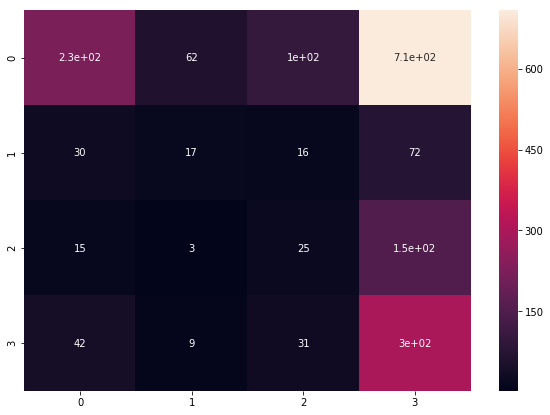

In [42]:
i_v = Input(shape=(21,35))
x = LSTM(units=64,return_sequences=True)(i_v)
x = LSTM(units=64,return_sequences=False)(x)
x = Dense(units=64,activation='relu')(x)
x = Dense(units=64,activation='relu')(x)
o_v = Dense(4,activation='softmax')(x)

m_v = Model(i_v,o_v)
m_v.compile('adam','categorical_crossentropy',metrics=['accuracy'])
print(m_v.summary())
es = EarlyStopping(monitor='val_acc',mode='max' ,patience=5, min_delta=0.0001,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,patience=2,min_lr=0.00001)
m_v.fit(Train_video,Y_train,128,epochs=100,validation_data=(Valid_video,Y_valid),callbacks=[es,reduce_lr])
print(m_v.evaluate(Test_video,Y_test))


print("###############################################################")
y_pred = np.argmax(m_v.predict(Test_video),axis=1)
y_true = np.argmax(Y_test,axis=1)
cm = confusion_matrix(y_true,y_pred)
np.save("cm_video.npy",cm)
df = pd.DataFrame(cm)
plt.figure(figsize = (10,7),)
print("UNIMODAL VISUAL RESULTS")
print(classification_report(y_true,y_pred,target_names=target_names))
sn.heatmap(cm, annot=True,xticklabels=True,yticklabels=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 21, 74)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 21, 128)           103936    
_________________________________________________________________
lstm_20 (LSTM)               (None, 21, 64)            49408     
_________________________________________________________________
lstm_21 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_31 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_32 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_33 (Dense)             (None, 4)                 260       
Total para

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


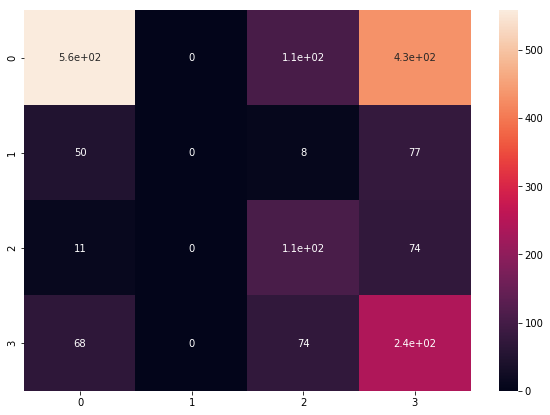

In [43]:
i_a = Input(shape=(21,74))
x = LSTM(units=128,return_sequences=True)(i_a)
x = LSTM(units=64,return_sequences=True)(x)
x = LSTM(units=64,return_sequences=False)(x)
x = Dense(units=64,activation='relu')(x)
x = Dense(units=64,activation='relu')(x)
o_a = Dense(4,activation='softmax')(x)

m_a = Model(i_a,o_a)
m_a.compile('adam','categorical_crossentropy',metrics=['accuracy'])
print(m_a.summary())
es = EarlyStopping(monitor='val_acc',mode='max' ,patience=5, min_delta=0.0001,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,patience=2,min_lr=0.00001)
m_a.fit(Train_audio,Y_train,128,epochs=100,validation_data=(Valid_audio,Y_valid),callbacks=[es,reduce_lr])
print(m_a.evaluate(Test_audio,Y_test))


print("###############################################################")
y_pred = np.argmax(m_a.predict(Test_audio),axis=1)
y_true = np.argmax(Y_test,axis=1)
cm = confusion_matrix(y_true,y_pred)
np.save("cm_audio.npy",cm)
df = pd.DataFrame(cm)
plt.figure(figsize = (10,7),)
print("UNIMODAL AUDIO RESULTS")
print(classification_report(y_true,y_pred,target_names=target_names))
sn.heatmap(cm, annot=True,xticklabels=True,yticklabels=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 21, 300)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 21, 256)           570368    
_________________________________________________________________
lstm_23 (LSTM)               (None, 21, 128)           197120    
_________________________________________________________________
lstm_24 (LSTM)               (None, 21, 64)            49408     
_________________________________________________________________
lstm_25 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_34 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_35 (Dense)             (None, 64)                4160      
__________

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


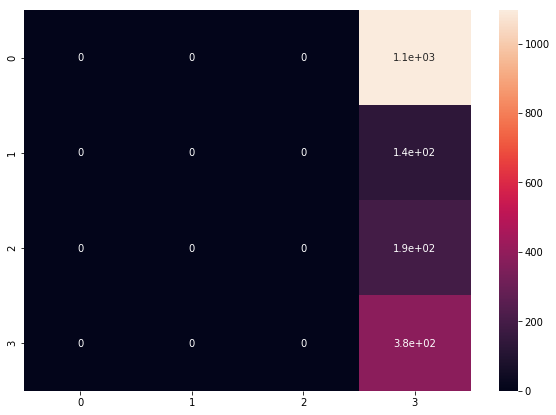

In [44]:
i_t = Input(shape=(21,300))
x = LSTM(units=256,return_sequences=True)(i_t)
x = LSTM(units=128,return_sequences=True)(x)
x = LSTM(units=64,return_sequences=True)(x)
x = LSTM(units=64,return_sequences=False)(x)
x = Dense(units=64,activation='relu')(x)
x = Dense(units=64,activation='relu')(x)
o_t = Dense(4,activation='softmax')(x)

m_t = Model(i_t,o_t)
m_t.compile('adam','categorical_crossentropy',metrics=['accuracy'])
print(m_t.summary())
es = EarlyStopping(monitor='val_acc',mode='max' ,patience=5, min_delta=0.0001,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,patience=2,min_lr=0.00001)
m_t.fit(Train_text,Y_train,128,epochs=100,validation_data=(Valid_text,Y_valid),callbacks=[es,reduce_lr])
print(m_t.evaluate(Test_text,Y_test))


print("###############################################################")
y_pred = np.argmax(m_t.predict(Test_text),axis=1)
y_true = np.argmax(Y_test,axis=1)
cm = confusion_matrix(y_true,y_pred)
np.save("cm_text.npy",cm)
df = pd.DataFrame(cm)
plt.figure(figsize = (10,7),)
print("UNIMODAL TEXT RESULTS")
print(classification_report(y_true,y_pred,target_names=target_names))
sn.heatmap(cm, annot=True,xticklabels=True,yticklabels=True)

In [0]:
m_v.save("unimodal_visual.h5")
m_t.save("unimodal_text.h5")
m_a.save("unimodal_audio.h5")

In [46]:

Train_concat = np.concatenate((Train_audio,Train_text,Train_video),axis=-1)
Test_concat = np.concatenate((Test_audio,Test_text,Test_video),axis=-1)
Valid_concat = np.concatenate((Valid_audio,Valid_text,Valid_video),axis=-1)

print(Train_concat.shape)
print(Test_concat.shape)
print(Valid_concat.shape)

(6373, 21, 409)
(1807, 21, 409)
(1775, 21, 409)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 21, 409)           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 21, 256)           681984    
_________________________________________________________________
lstm_27 (LSTM)               (None, 21, 128)           197120    
_________________________________________________________________
lstm_28 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_37 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
__________

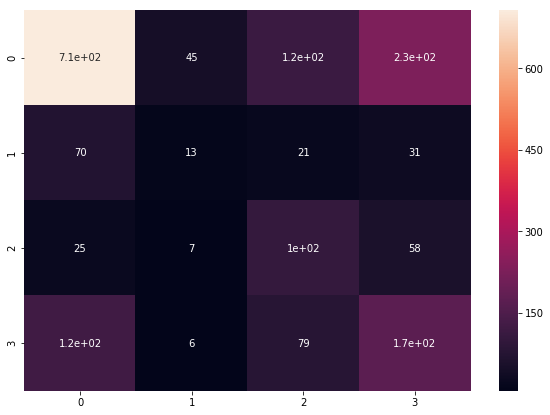

In [47]:
i_c = Input(shape=(21,409))
x = LSTM(units=256,return_sequences=True)(i_c)
x = LSTM(units=128,return_sequences=True)(x)
x = LSTM(units=64,return_sequences=False)(x)
x = Dense(units=64,activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64,activation='relu')(x)
o_c = Dense(4,activation='softmax')(x)

m_c = Model(i_c,o_c)
m_c.compile('adam','categorical_crossentropy',metrics=['accuracy'])
print(m_c.summary())
es = EarlyStopping(monitor='val_acc',mode='max' ,patience=5, min_delta=0.0001,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,patience=2,min_lr=0.00001)
m_c.fit(Train_concat,Y_train,128,epochs=100,validation_data=(Valid_concat,Y_valid),callbacks=[es,reduce_lr])
print(m_c.evaluate(Test_concat,Y_test))


print("###############################################################")
y_pred = np.argmax(m_c.predict(Test_concat),axis=1)
y_true = np.argmax(Y_test,axis=1)
cm = confusion_matrix(y_true,y_pred)
np.save("cm_early_fusion.npy",cm)
df = pd.DataFrame(cm)
plt.figure(figsize = (10,7),)
print("Early Fusion RESULTS")
print(classification_report(y_true,y_pred,target_names=target_names))
sn.heatmap(cm, annot=True,xticklabels=True,yticklabels=True)

In [0]:
m_c.save("early_fusion.h5")

In [0]:
m_v = load_model("unimodal_visual.h5")
m_a = load_model("unimodal_audio.h5")
m_t = load_model("unimodal_text.h5")

In [50]:
print(m_v.summary())
print(m_a.summary())
print(m_t.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 21, 35)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 21, 64)            25600     
_________________________________________________________________
lstm_18 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 260       
Total params: 67,204
Trainable params: 67,204
Non-trainable params: 0
_________________________________________________________________
None
_

In [51]:
model_v = Sequential()
model_a = Sequential()
model_t = Sequential()

for layer in m_v.layers[:-1]:
  layer.trainable = False
  model_v.add(layer)
  
for layer in m_a.layers[:-1]:
  layer.trainable = False
  model_a.add(layer)
for layer in m_t.layers[:-1]:
  layer.trainable = False
  model_t.add(layer)
  
print(model_v.summary())
print(model_a.summary())
print(model_t.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 21, 64)            25600     
_________________________________________________________________
lstm_18 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 64)                4160      
Total params: 66,944
Trainable params: 0
Non-trainable params: 66,944
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 21, 128)           103936    
_________________________________________________________________
l

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 21, 74)       0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           (None, 21, 35)       0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           (None, 21, 300)      0                                            
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 64)           194688      input_22[0][0]                   
__________________________________________________________________________________________________
sequential

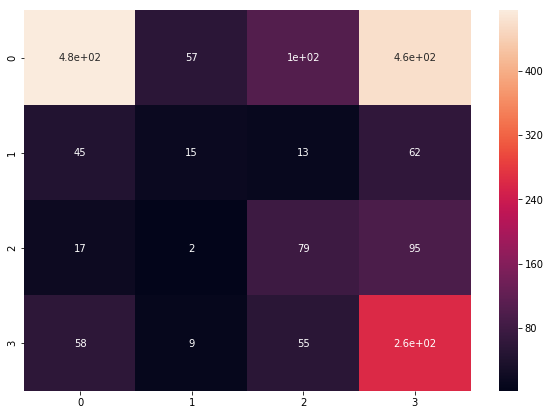

In [52]:
i_a = Input(shape=(21,74))
i_v = Input(shape=(21,35))
i_t = Input(shape=(21,300))

merged = concatenate([model_a(i_a),model_v(i_v),model_t(i_t)])
y = Dense(64,activation='relu')(merged)
# y = Dense(64,activation='relu')(y)
y = Dense(4,activation='softmax')(y)

model = Model([i_a,i_v,i_t],y)
model.compile('adam','categorical_crossentropy',metrics=['accuracy'])
print(model.summary())
es = EarlyStopping(monitor='val_acc',mode='max' ,patience=5, min_delta=0.0001,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,patience=2,min_lr=0.00001)
model.fit([Train_audio,Train_video,Train_text],Y_train,128,epochs=100,validation_data=([Valid_audio,Valid_video,Valid_text],Y_valid),callbacks=[es,reduce_lr])
print(model.evaluate([Test_audio,Test_video,Test_text],Y_test))


print("###############################################################")
y_pred = np.argmax(model.predict([Test_audio,Test_video,Test_text]),axis=1)
y_true = np.argmax(Y_test,axis=1)
cm = confusion_matrix(y_true,y_pred)
np.save("cm_early_fusion.npy",cm)
df = pd.DataFrame(cm)
plt.figure(figsize = (10,7),)
print("Early Fusion RESULTS")
print(classification_report(y_true,y_pred,target_names=target_names))
sn.heatmap(cm, annot=True,xticklabels=True,yticklabels=True)

In [0]:
model.save("late_fusion.h5")

In [0]:
model_v = Sequential()
model_a = Sequential()
model_t = Sequential()

for layer in m_v.layers[:-1]:
  layer.trainable = False
  model_v.add(layer)
  
for layer in m_a.layers[:-1]:
  layer.trainable = False
  model_a.add(layer)
for layer in m_t.layers[:-1]:
  layer.trainable = False
  model_t.add(layer)

def tensor_fuse(out):
	o1 = out[0]     
	o2 = out[1]     
	o3 = out[2]     

	x = tf.expand_dims(o1,1)  
	y = tf.expand_dims(o2,2)   
	o12 = tf.reshape(tf.multiply(x,y),shape=[-1,64*64])   

	x = tf.expand_dims(o2,1)    
	y = tf.expand_dims(o3,2)   
	o23 = tf.reshape(tf.multiply(x,y),shape=[-1,64*64])   
  
	x = tf.expand_dims(o3,1)    
	y = tf.expand_dims(o1,2)    
	o31 = tf.reshape(tf.multiply(x,y),shape=[-1,64*64])   

	x = tf.expand_dims(o12,2)   
	y = tf.expand_dims(o3,1)    
	o123 = tf.reshape(tf.multiply(x,y),[-1,64*64*64])   

	return concatenate([o1,o2,o3,o12,o23,o31])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 21, 74)       0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           (None, 21, 35)       0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           (None, 21, 300)      0                                            
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 64)           194688      input_25[0][0]                   
__________________________________________________________________________________________________
sequential

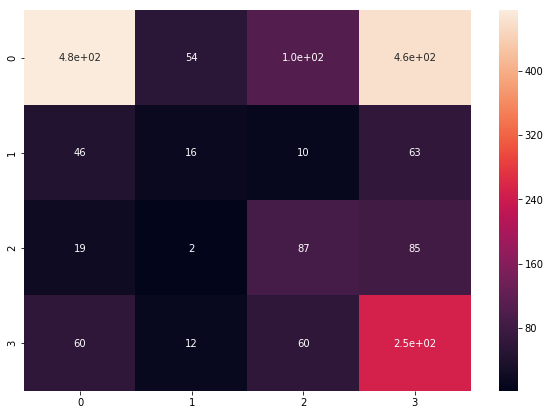

In [55]:
i_a = Input(shape=(21,74))
i_v = Input(shape=(21,35))
i_t = Input(shape=(21,300))

merged = layers.Lambda(tensor_fuse)([model_a(i_a),model_v(i_v),model_t(i_t)])
y = Dense(1024,activation='relu')(merged)
y = Dense(512,activation='relu')(y)
y = Dense(64,activation='relu')(y)
y = Dense(4,activation='softmax')(y)



model = Model([i_a,i_v,i_t],y)
model.compile('adam','categorical_crossentropy',metrics=['accuracy'])
print(model.summary())
es = EarlyStopping(monitor='val_acc',mode='max' ,patience=5, min_delta=0.0001,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,patience=2,min_lr=0.00001)
model.fit([Train_audio,Train_video,Train_text],Y_train,128,epochs=100,validation_data=([Valid_audio,Valid_video,Valid_text],Y_valid),callbacks=[es,reduce_lr])
print(model.evaluate([Test_audio,Test_video,Test_text],Y_test))


print("###############################################################")
y_pred = np.argmax(model.predict([Test_audio,Test_video,Test_text]),axis=1)
y_true = np.argmax(Y_test,axis=1)
cm = confusion_matrix(y_true,y_pred)
np.save("cm_early_fusion.npy",cm)
df = pd.DataFrame(cm)
plt.figure(figsize = (10,7),)
print("Early Fusion RESULTS")
print(classification_report(y_true,y_pred,target_names=target_names))
sn.heatmap(cm, annot=True,xticklabels=True,yticklabels=True)

In [0]:
model.save("tensor_fusion.h5")

In [0]:

def deep_fuse(out):
  o1 = out[0]     # o1.shape = (None,32)
  o2 = out[1]     # o2.shape = (None,32)
  o3 = out[2]     # o3.shape = (None,32)

  x = 1.-o1
  y = 1.-o2
  z = 1.-o3

  return concatenate([o1,o2,o3,x,y,z])

In [0]:
model_v = Sequential()
model_a = Sequential()
model_t = Sequential()

for layer in m_v.layers[:]:
  layer.trainable = False
  model_v.add(layer)
  
for layer in m_a.layers[:]:
  layer.trainable = False
  model_a.add(layer)
for layer in m_t.layers[:]:
  layer.trainable = False
  model_t.add(layer)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 21, 74)       0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           (None, 21, 35)       0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           (None, 21, 300)      0                                            
__________________________________________________________________________________________________
model_11 (Model)                (None, 4)            194948      input_28[0][0]                   
__________________________________________________________________________________________________
model_10 (

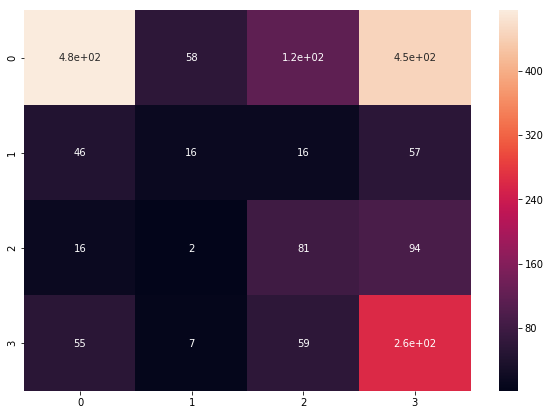

In [59]:
i_a = Input(shape=(21,74))
i_v = Input(shape=(21,35))
i_t = Input(shape=(21,300))

merged = Lambda(deep_fuse)([m_a(i_a),m_v(i_v),m_t(i_t)])

y = Dense(64,activation='relu')(merged)
y = Dense(64,activation='relu')(y)
y = Dense(4,activation='softmax')(y)

model = Model([i_a,i_v,i_t],y)
model.compile('adam','categorical_crossentropy',metrics=['accuracy'])
print(model.summary())
es = EarlyStopping(monitor='val_acc',mode='max' ,patience=5, min_delta=0.0001,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,patience=2,min_lr=0.00001)
model.fit([Train_audio,Train_video,Train_text],Y_train,128,epochs=100,validation_data=([Valid_audio,Valid_video,Valid_text],Y_valid),callbacks=[es,reduce_lr])
print(model.evaluate([Test_audio,Test_video,Test_text],Y_test))


print("###############################################################")
y_pred = np.argmax(model.predict([Test_audio,Test_video,Test_text]),axis=1)
y_true = np.argmax(Y_test,axis=1)
cm = confusion_matrix(y_true,y_pred)
np.save("cm_deep_fusion.npy",cm)
df = pd.DataFrame(cm)
plt.figure(figsize = (10,7),)
print("Early Fusion RESULTS")
print(classification_report(y_true,y_pred,target_names=target_names))
sn.heatmap(cm, annot=True,xticklabels=True,yticklabels=True)

In [0]:
model.save("deep_fusion.h5")

In [106]:
for n in range(6373):
  a=0
  v=0
  t=0
  for i in range(21):
    if(np.count_nonzero(Train_audio[n][i])==0):
      a=a+1
    if(np.count_nonzero(Train_text[n][i])==0):
      t=t+1
    if(np.count_nonzero(Train_video[n][i])==0):
      v=v+1
  print(a,v,t)

9 9 6
20 21 20
19 19 19
13 13 12
14 17 11
11 14 0
7 8 0
10 10 7
20 20 20
11 17 8
2 6 1
20 20 19
17 19 17
16 16 14
18 18 18
20 20 20
20 20 20
9 8 3
18 21 17
12 14 12
17 17 17
12 20 12
9 11 0
9 10 8
18 18 18
16 16 16
13 17 13
16 21 16
10 20 7
15 19 16
18 21 16
15 19 15
8 21 2
7 17 2
6 21 2
13 19 14
18 21 16
17 21 17
14 21 12
10 20 8
14 21 13
17 21 17
7 19 3
12 20 14
7 16 3
10 19 5
16 21 17
12 21 12
19 19 18
19 20 19
9 11 8
19 19 19
7 19 2
18 21 17
19 21 19
15 21 13
6 14 6
15 19 14
18 21 18
12 19 10
20 20 20
17 17 18
14 17 13
14 21 14
19 19 19
8 21 0
15 19 13
6 16 0
15 21 14
7 15 3
9 20 1
18 21 18
16 20 16
16 20 16
11 21 9
15 21 15
15 19 15
14 20 9
6 20 2
7 21 2
20 20 20
12 19 1
16 18 16
13 21 9
10 19 10
16 20 16
18 21 18
7 19 1
14 17 14
8 12 5
7 19 3
16 21 16
20 20 20
9 20 10
10 21 10
20 21 20
3 18 2
7 18 1
10 21 10
5 21 3
12 21 12
17 21 18
15 19 15
16 21 16
15 21 15
11 17 10
4 19 0
15 21 12
16 19 16
14 21 13
7 21 0
19 21 20
7 18 5
8 18 6
13 21 10
14 20 11
13 21 10
13 20 13
18 21 18
10 1

In [93]:
print(Train_audio[1])

[[ 2.43556818e+02  5.45454545e-01  4.64719034e-02 ... -1.22010863e-01
  -1.05709435e-01 -5.43968786e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


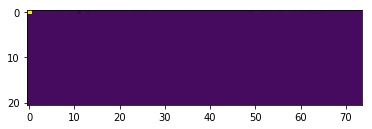

In [72]:
matplotlib.pyplot.imshow(Train_audio[1])

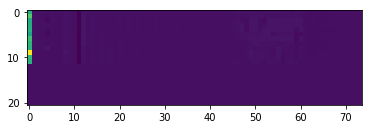

In [74]:
matplotlib.pyplot.imshow(Train_audio[0])
# matplotlib.pyplot.imshow(Train_audio[3])

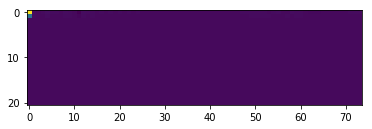

In [75]:
matplotlib.pyplot.imshow(Train_audio[2],)

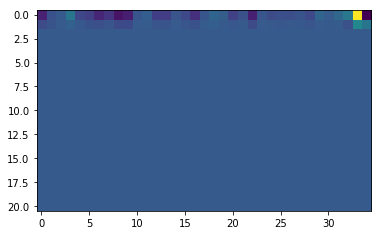

In [76]:
matplotlib.pyplot.imshow(Train_video[2])

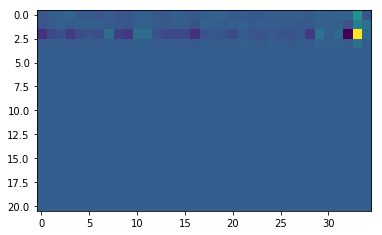

In [78]:
matplotlib.pyplot.imshow(Train_video[4])

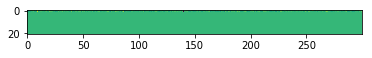

In [79]:
matplotlib.pyplot.imshow(Train_text[2])

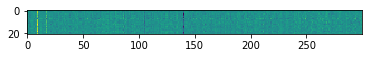

In [81]:
matplotlib.pyplot.imshow(Train_text[6])

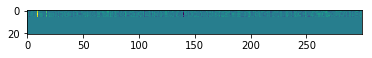

In [82]:
matplotlib.pyplot.imshow(Train_text[133])

In [95]:
!wget "https://github.com/SenticNet/hfusion/blob/master/unimodal.pickle"

--2019-07-13 08:35:03--  https://github.com/SenticNet/hfusion/blob/master/unimodal.pickle
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘unimodal.pickle’

unimodal.pickle         [ <=>                ]  63.12K  --.-KB/s    in 0.06s   

2019-07-13 08:35:03 (1.00 MB/s) - ‘unimodal.pickle’ saved [64635]



In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
from sklearn.decomposition import PCA

In [183]:
import pickle

Train_video = pickle.load(open("data/facet_train.p",'rb'),encoding='latin1')
Test_video = pickle.load(open("data/facet_test.p",'rb'),encoding='latin1')
Valid_video = pickle.load(open("data/facet_valid.p",'rb'),encoding='latin1')

Train_text = pickle.load(open("data/text_train.p",'rb'),encoding='latin1')
Test_text = pickle.load(open("data/text_test.p",'rb'),encoding='latin1')
Valid_text = pickle.load(open("data/text_valid.p",'rb'),encoding='latin1')

Train_audio = pickle.load(open("data/covarep_train.p",'rb'),encoding='latin1')
Test_audio = pickle.load(open("data/covarep_test.p",'rb'),encoding='latin1')
Valid_audio = pickle.load(open("data/covarep_valid.p",'rb'),encoding='latin1')

Y_train =  pickle.load(open("data/y_train.p",'rb'),encoding='latin1')
Y_test =  pickle.load(open("data/y_test.p",'rb'),encoding='latin1')
Y_valid =  pickle.load(open("data/y_valid.p",'rb'),encoding='latin1')

Y_train = Y_train[:,1:-1]  # selecting only emotion label and ignoring others and unknown
Y_test = Y_test[:,1:-1]    # regarding 11 features:
Y_valid = Y_valid[:,1:-1]  # Other Anger Excited Fear Sad Surprised Frustrated Happy Neutral Disgust (unknown)


Y_train =  pickle.load(open("data/y_train.p",'rb'),encoding='latin1')
Y_test =  pickle.load(open("data/y_test.p",'rb'),encoding='latin1')
Y_valid =  pickle.load(open("data/y_valid.p",'rb'),encoding='latin1')

Y_train = Y_train[:,1:-1]  # selecting only emotion label and ignoring others and unknown
Y_test = Y_test[:,1:-1]    # regarding 11 features:
Y_valid = Y_valid[:,1:-1]  # Other Anger Excited Fear Sad Surprised Frustrated Happy Neutral Disgust (unknown)


Y_train = Y_train[:,[0,1,3,5,6,7]]
Y_test = Y_test[:,[0,1,3,5,6,7]]
Y_valid = Y_valid[:,[0,1,3,5,6,7]]
target_names = ['Anger','Excited','Sad','Frustrated','Happy','Neutral']
map = {0:"Anger",1:"Excited",2:"Fear",3:"Sad",4:"Surprised",5:"Frustrated",6:"Happy",7:"Neutral",8:"Disgust"}
print(Train_video.shape,Test_video.shape,Valid_video.shape)
print(Train_text.shape,Test_text.shape,Valid_text.shape)
print(Train_audio.shape,Test_audio.shape,Valid_audio.shape)
print(Y_train.shape,Y_test.shape,Y_valid.shape)

(6373, 21, 35) (1807, 21, 35) (1775, 21, 35)
(6373, 21, 300) (1807, 21, 300) (1775, 21, 300)
(6373, 21, 74) (1807, 21, 74) (1775, 21, 74)
(6373, 6) (1807, 6) (1775, 6)


In [184]:
X_audio = np.zeros(shape=(6373,20,30))
pca = PCA(n_components=30)
for i in range(0,20):
  x = Train_audio[:,i,:]
  x = sc.fit_transform(x)
  x = pca.fit_transform(x)
  X_audio[:,i,:] = x
Train_audio = X_audio
print(X_audio.shape) 
print(pca.explained_variance_)

X_audio = np.zeros(shape=(1807,20,30))
for i in range(0,20):
  x = Test_audio[:,i,:]
  x = sc.fit_transform(x)
  x = pca.fit_transform(x)
  X_audio[:,i,:] = x
Test_audio = X_audio
print(X_audio.shape) 
print(pca.explained_variance_)


X_audio = np.zeros(shape=(1775,20,30))
for i in range(0,19):
  x = Valid_audio[:,i,:]
  x = sc.fit_transform(x)
  x = pca.fit_transform(x)
  X_audio[:,i,:] = x
Valid_audio = X_audio
print(X_audio.shape) 
print(pca.explained_variance_)

(6373, 20, 30)
[3.58969205e+01 1.76841813e+01 6.75497583e+00 5.62642556e+00
 3.05992913e+00 7.98767337e-01 1.89785908e-01 7.45663094e-29
 3.58271688e-31 3.58271688e-31 3.58271688e-31 3.58271688e-31
 3.58271688e-31 3.58271688e-31 3.58271688e-31 3.58271688e-31
 3.58271688e-31 3.58271688e-31 3.58271688e-31 3.58271688e-31
 3.58271688e-31 3.58271688e-31 3.58271688e-31 3.58271688e-31
 3.58271688e-31 3.58271688e-31 3.58271688e-31 3.58271688e-31
 3.58271688e-31 3.58271688e-31]
(1807, 20, 30)
[6.20343300e+01 1.05502293e-29 6.19352043e-31 6.19352043e-31
 6.19352043e-31 6.19352043e-31 6.19352043e-31 6.19352043e-31
 6.19352043e-31 6.19352043e-31 6.19352043e-31 6.19352043e-31
 6.19352043e-31 6.19352043e-31 6.19352043e-31 6.19352043e-31
 6.19352043e-31 6.19352043e-31 6.19352043e-31 6.19352043e-31
 6.19352043e-31 6.19352043e-31 6.19352043e-31 6.19352043e-31
 6.19352043e-31 6.19352043e-31 6.19352043e-31 6.19352043e-31
 6.19352043e-31 6.19352043e-31]
(1775, 20, 30)
[4.55134379e+01 1.77496168e+01 6.2680

In [185]:
X_text = np.zeros(shape=(6373,20,100))
pca = PCA(n_components=100)
for i in range(0,20):
  x = Train_text[:,i,:]
  x = sc.fit_transform(x)
  x = pca.fit_transform(x)
  X_text[:,i,:] = x
Train_text = X_text
print(X_text.shape) 
print(pca.explained_variance_)

X_text = np.zeros(shape=(1807,20,100))
for i in range(0,20):
  x = Test_text[:,i,:]
  x = sc.fit_transform(x)
  x = pca.fit_transform(x)
  X_text[:,i,:] = x
Test_text = X_text
print(X_text.shape) 
print(pca.explained_variance_)


X_text = np.zeros(shape=(1775,20,100))
for i in range(0,19):
  x = Valid_text[:,i,:]
  x = sc.fit_transform(x)
  x = pca.fit_transform(x)
  X_text[:,i,:] = x
Valid_text = X_text
print(X_text.shape) 
print(pca.explained_variance_)

(6373, 20, 100)
[37.5079766  18.83670921 12.56531824  9.92111055  9.79688047  8.88105731
  8.30240832  7.41554186  6.93561571  6.16225823  5.58762476  5.29862978
  5.06747753  4.59501802  4.41581225  4.2606274   4.11930044  3.87753961
  3.76628528  3.64870322  3.34110929  3.32702205  3.26093333  3.16566421
  2.95857019  2.92383244  2.7452598   2.72875891  2.58641398  2.47637867
  2.41277226  2.36705894  2.18938651  2.12224206  2.1028411   2.0399746
  1.98265021  1.94074267  1.93553902  1.83568162  1.78977444  1.76625293
  1.68925499  1.64018954  1.56881286  1.54152821  1.48804792  1.46924498
  1.41307893  1.37636885  1.35577862  1.32861041  1.29220414  1.28712869
  1.24337198  1.23601017  1.17864408  1.15649025  1.14861863  1.14367658
  1.08766981  1.03995863  1.03382852  0.99484474  0.98349425  0.96519308
  0.95357864  0.9302226   0.91736537  0.9073985   0.88972177  0.8629508
  0.82899365  0.82156504  0.81092802  0.78531114  0.76327583  0.74944167
  0.71504989  0.71075772  0.69464203 

In [202]:
Train_video = pickle.load(open("data/facet_train.p",'rb'),encoding='latin1')
Test_video = pickle.load(open("data/facet_test.p",'rb'),encoding='latin1')
Valid_video = pickle.load(open("data/facet_valid.p",'rb'),encoding='latin1')
X_video = np.zeros(shape=(6373,20,20))
pca = PCA(n_components=20)
for i in range(0,20):
  x = Train_video[:,i,:]
  x = sc.fit_transform(x)
  x = pca.fit_transform(x)
  X_video[:,i,:] = x
Train_video = X_video
print(X_video.shape) 
print(pca.explained_variance_)

X_video = np.zeros(shape=(1807,20,20))
for i in range(0,19):
  x = Test_video[:,i,:]
  x = sc.fit_transform(x)
  x = pca.fit_transform(x)
  X_video[:,i,:] = x
Test_video = X_video
print(X_video.shape) 
print(pca.explained_variance_)


X_video = np.zeros(shape=(1775,20,20))
for i in range(0,19):
  x = Valid_video[:,i,:]
  x = sc.fit_transform(x)
  x = pca.fit_transform(x)
  X_video[:,i,:] = x
Valid_video = X_video
print(X_video.shape) 
print(pca.explained_variance_)

(6373, 20, 20)
[2.45152128e+01 9.77714062e+00 5.23951398e-01 1.89187940e-01
 6.65746276e-30 2.44752244e-31 2.44752244e-31 2.44752244e-31
 2.44752244e-31 2.44752244e-31 2.44752244e-31 2.44752244e-31
 2.44752244e-31 2.44752244e-31 2.44752244e-31 2.44752244e-31
 2.44752244e-31 2.44752244e-31 2.44752244e-31 2.44752244e-31]
(1807, 20, 20)
[2.35717424e+01 9.86050546e+00 1.47641867e+00 1.09876014e-01
 8.37310551e-04 4.43575213e-30 2.35339330e-31 2.35339330e-31
 2.35339330e-31 2.35339330e-31 2.35339330e-31 2.35339330e-31
 2.35339330e-31 2.35339330e-31 2.35339330e-31 2.35339330e-31
 2.35339330e-31 2.35339330e-31 2.35339330e-31 2.35339330e-31]
(1775, 20, 20)
[3.50197294e+01 6.57326487e-31 3.49637708e-31 3.49637708e-31
 3.49637708e-31 3.49637708e-31 3.49637708e-31 3.49637708e-31
 3.49637708e-31 3.49637708e-31 3.49637708e-31 3.49637708e-31
 3.49637708e-31 3.49637708e-31 3.49637708e-31 3.49637708e-31
 3.49637708e-31 3.49637708e-31 3.49637708e-31 3.49637708e-31]


In [203]:
print(Train_video.shape,Test_video.shape,Valid_video.shape)
print(Train_text.shape,Test_text.shape,Valid_text.shape)
print(Train_audio.shape,Test_audio.shape,Valid_audio.shape)
print(Y_train.shape,Y_test.shape,Y_valid.shape)

(6373, 20, 20) (1807, 20, 20) (1775, 20, 20)
(6373, 20, 100) (1807, 20, 100) (1775, 20, 100)
(6373, 20, 30) (1807, 20, 30) (1775, 20, 30)
(6373, 6) (1807, 6) (1775, 6)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 20, 20)            0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 20, 64)            21760     
_________________________________________________________________
lstm_45 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_79 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_80 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_81 (Dense)             (None, 6)                 390       
Total params: 63,494
Trainable params: 63,494
Non-trainable params: 0
_________________________________________________________________
None
T

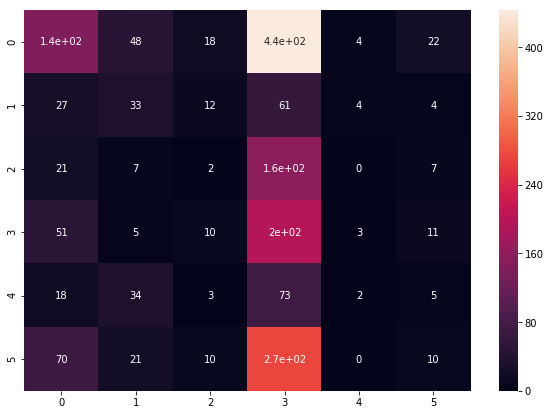

In [204]:

i_v = Input(shape=(20,20))
x = LSTM(units=64,return_sequences=True)(i_v)
x = LSTM(units=64,return_sequences=False)(x)
x = Dense(units=64,activation='relu')(x)
x = Dense(units=64,activation='relu')(x)
o_v = Dense(6,activation='softmax')(x)

m_v = Model(i_v,o_v)
m_v.compile('adam','categorical_crossentropy',metrics=['accuracy'])
print(m_v.summary())
es = EarlyStopping(monitor='val_acc',mode='max' ,patience=5, min_delta=0.0001,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,patience=2,min_lr=0.00001)
m_v.fit(Train_video,Y_train,128,epochs=100,validation_data=(Valid_video,Y_valid),callbacks=[es,reduce_lr])
print(m_v.evaluate(Test_video,Y_test))


print("###############################################################")
y_pred = np.argmax(m_v.predict(Test_video),axis=1)
y_true = np.argmax(Y_test,axis=1)
cm = confusion_matrix(y_true,y_pred)
np.save("cm_video.npy",cm)
df = pd.DataFrame(cm)
plt.figure(figsize = (10,7),)
print("UNIMODAL VISUAL RESULTS")
print(classification_report(y_true,y_pred,target_names=target_names))
sn.heatmap(cm, annot=True,xticklabels=True,yticklabels=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        (None, 20, 30)            0         
_________________________________________________________________
lstm_54 (LSTM)               (None, 20, 64)            24320     
_________________________________________________________________
lstm_55 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_91 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_92 (Dense)             (None, 6)                 390       
Total params: 61,894
Trainable params: 61,894
Non-trainable params: 0
_________________________________________________________________
None
Train on 6373 samples, validate on 1775 samples
Epoch 1/100
6373/6373 [==============================] - 24s 4ms/step - loss: 1.2519 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


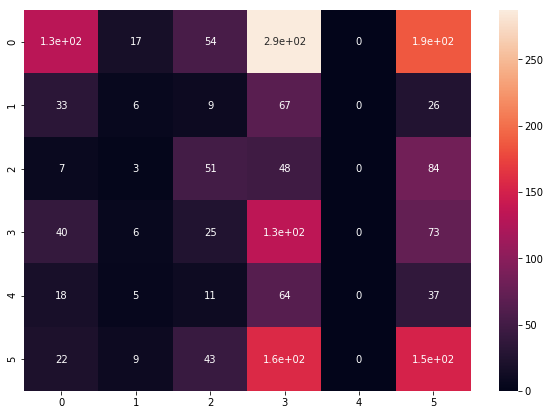

In [208]:
i_a = Input(shape=(20,30))
x = LSTM(units=64,return_sequences=True)(i_a)
# x = LSTM(units=64,return_sequences=True)(x)
x = LSTM(units=64,return_sequences=False)(x)
# x = Dense(units=64,activation='relu')(x)
x = Dense(units=64,activation='relu')(x)
o_a = Dense(6,activation='softmax')(x)

m_a = Model(i_a,o_a)
m_a.compile('adam','categorical_crossentropy',metrics=['accuracy'])
print(m_a.summary())
es = EarlyStopping(monitor='val_acc',mode='max' ,patience=5, min_delta=0.0001,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,patience=2,min_lr=0.00001)
m_a.fit(Train_audio,Y_train,128,epochs=100,validation_data=(Valid_audio,Y_valid),callbacks=[es,reduce_lr])
print(m_a.evaluate(Test_audio,Y_test))


print("###############################################################")
y_pred = np.argmax(m_a.predict(Test_audio),axis=1)
y_true = np.argmax(Y_test,axis=1)
cm = confusion_matrix(y_true,y_pred)
np.save("cm_audio.npy",cm)
df = pd.DataFrame(cm)
plt.figure(figsize = (10,7),)
print("UNIMODAL AUDIO RESULTS")
print(classification_report(y_true,y_pred,target_names=target_names))
sn.heatmap(cm, annot=True,xticklabels=True,yticklabels=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        (None, 20, 100)           0         
_________________________________________________________________
lstm_63 (LSTM)               (None, 20, 64)            42240     
_________________________________________________________________
lstm_64 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_101 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_102 (Dense)            (None, 6)                 390       
Total params: 79,814
Trainable params: 79,814
Non-trainable params: 0
_________________________________________________________________
None
Train on 6373 samples, validate on 1775 samples
Epoch 1/100
6373/6373 [==============================] - 26s 4ms/step - loss: 1.2689 

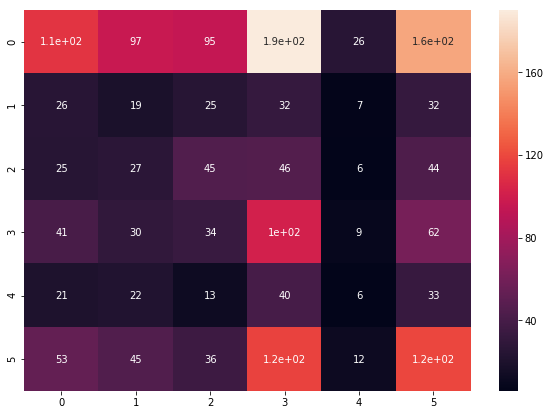

In [212]:
i_t = Input(shape=(20,100))
x = LSTM(units=64,return_sequences=True)(i_t)
# x = LSTM(units=64,return_sequences=True)(x)
x = LSTM(units=64,return_sequences=False)(x)
# x = Dense(units=64,activation='relu')(x)
x = Dense(units=64,activation='relu')(x)
o_t = Dense(6,activation='softmax')(x)

m_t = Model(i_t,o_t)
m_t.compile('adam','categorical_crossentropy',metrics=['accuracy'])
print(m_t.summary())
es = EarlyStopping(monitor='val_acc',mode='max' ,patience=5, min_delta=0.0001,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,patience=2,min_lr=0.00001)
m_t.fit(Train_text,Y_train,128,epochs=100,validation_data=(Valid_text,Y_valid),callbacks=[es,reduce_lr])
print(m_t.evaluate(Test_text,Y_test))


print("###############################################################")
y_pred = np.argmax(m_t.predict(Test_text),axis=1)
y_true = np.argmax(Y_test,axis=1)
cm = confusion_matrix(y_true,y_pred)
np.save("cm_text.npy",cm)
df = pd.DataFrame(cm)
plt.figure(figsize = (10,7),)
print("UNIMODAL TEXT RESULTS")
print(classification_report(y_true,y_pred,target_names=target_names))
sn.heatmap(cm, annot=True,xticklabels=True,yticklabels=True)

In [0]:
m_v.save("unimodal_visual.h5")
m_t.save("unimodal_text.h5")
m_a.save("unimodal_audio.h5")

In [214]:
Train_concat = np.concatenate((Train_audio,Train_text,Train_video),axis=-1)
Test_concat = np.concatenate((Test_audio,Test_text,Test_video),axis=-1)
Valid_concat = np.concatenate((Valid_audio,Valid_text,Valid_video),axis=-1)

print(Train_concat.shape)
print(Test_concat.shape)
print(Valid_concat.shape)

(6373, 20, 150)
(1807, 20, 150)
(1775, 20, 150)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        (None, 20, 150)           0         
_________________________________________________________________
lstm_65 (LSTM)               (None, 20, 256)           416768    
_________________________________________________________________
lstm_66 (LSTM)               (None, 20, 128)           197120    
_________________________________________________________________
lstm_67 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_103 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_104 (Dense)            (None, 64)                4160      
__________

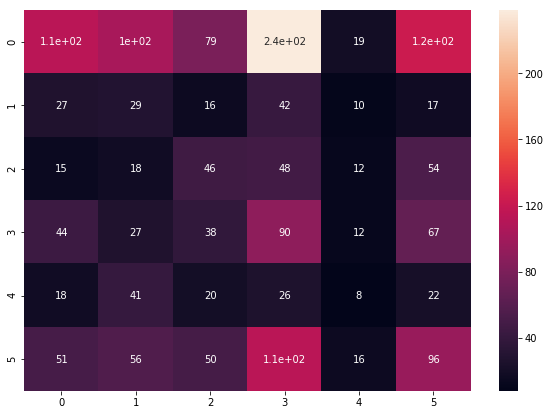

In [215]:
i_c = Input(shape=(20,150))
x = LSTM(units=256,return_sequences=True)(i_c)
x = LSTM(units=128,return_sequences=True)(x)
x = LSTM(units=64,return_sequences=False)(x)
x = Dense(units=64,activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64,activation='relu')(x)
o_c = Dense(6,activation='softmax')(x)

m_c = Model(i_c,o_c)
m_c.compile('adam','categorical_crossentropy',metrics=['accuracy'])
print(m_c.summary())
es = EarlyStopping(monitor='val_acc',mode='max' ,patience=5, min_delta=0.0001,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,patience=2,min_lr=0.00001)
m_c.fit(Train_concat,Y_train,128,epochs=100,validation_data=(Valid_concat,Y_valid),callbacks=[es,reduce_lr])
print(m_c.evaluate(Test_concat,Y_test))


print("###############################################################")
y_pred = np.argmax(m_c.predict(Test_concat),axis=1)
y_true = np.argmax(Y_test,axis=1)
cm = confusion_matrix(y_true,y_pred)
np.save("cm_early_fusion.npy",cm)
df = pd.DataFrame(cm)
plt.figure(figsize = (10,7),)
print("Early Fusion RESULTS")
print(classification_report(y_true,y_pred,target_names=target_names))
sn.heatmap(cm, annot=True,xticklabels=True,yticklabels=True)

In [216]:
model_v = Sequential()
model_a = Sequential()
model_t = Sequential()

for layer in m_v.layers[:-1]:
  layer.trainable = False
  model_v.add(layer)
  
for layer in m_a.layers[:-1]:
  layer.trainable = False
  model_a.add(layer)
for layer in m_t.layers[:-1]:
  layer.trainable = False
  model_t.add(layer)
  
print(model_v.summary())
print(model_a.summary())
print(model_t.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 20, 64)            21760     
_________________________________________________________________
lstm_45 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_79 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_80 (Dense)             (None, 64)                4160      
Total params: 63,104
Trainable params: 0
Non-trainable params: 63,104
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 20, 64)            24320     
_________________________________________________________________
l

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           (None, 20, 30)       0                                            
__________________________________________________________________________________________________
input_55 (InputLayer)           (None, 20, 20)       0                                            
__________________________________________________________________________________________________
input_56 (InputLayer)           (None, 20, 100)      0                                            
__________________________________________________________________________________________________
sequential_20 (Sequential)      (None, 64)           61504       input_54[0][0]                   
__________________________________________________________________________________________________
sequential

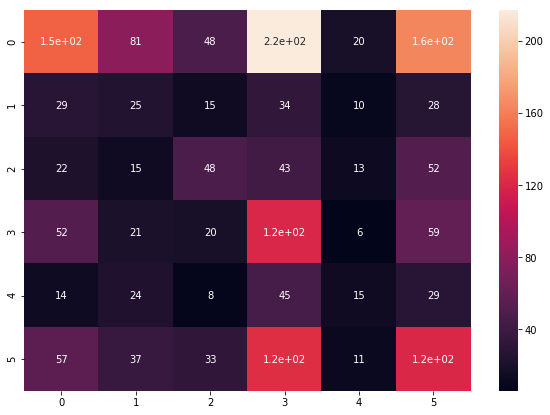

In [218]:
i_a = Input(shape=(20,30))
i_v = Input(shape=(20,20))
i_t = Input(shape=(20,100))

merged = concatenate([model_a(i_a),model_v(i_v),model_t(i_t)])
y = Dense(64,activation='relu')(merged)
# y = Dense(64,activation='relu')(y)
y = Dense(6,activation='softmax')(y)

model = Model([i_a,i_v,i_t],y)
model.compile('adam','categorical_crossentropy',metrics=['accuracy'])
print(model.summary())
es = EarlyStopping(monitor='val_acc',mode='max' ,patience=5, min_delta=0.0001,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,patience=2,min_lr=0.00001)
model.fit([Train_audio,Train_video,Train_text],Y_train,128,epochs=100,validation_data=([Valid_audio,Valid_video,Valid_text],Y_valid),callbacks=[es,reduce_lr])
print(model.evaluate([Test_audio,Test_video,Test_text],Y_test))


print("###############################################################")
y_pred = np.argmax(model.predict([Test_audio,Test_video,Test_text]),axis=1)
y_true = np.argmax(Y_test,axis=1)
cm = confusion_matrix(y_true,y_pred)
np.save("cm_early_fusion.npy",cm)
df = pd.DataFrame(cm)
plt.figure(figsize = (10,7),)
print("Early Fusion RESULTS")
print(classification_report(y_true,y_pred,target_names=target_names))
sn.heatmap(cm, annot=True,xticklabels=True,yticklabels=True)